# Step 1: 
### DATA preparation

### insert data and missing data check

In [2]:
#insert data

import pandas as pd
import numpy as np

Diabet = pd.read_csv("C:/Users/Administrator/git/Diabets/Diabetes Dataset/diabetes.csv")

In [5]:
Diabet.columns

Index(['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin',
       'BMI', 'DiabetesPedigreeFunction', 'Age', 'Outcome'],
      dtype='object')

In [4]:
#Missing Datas

Diabet.isnull().sum()

Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64

##### no missing data so no handling

### Basic Info & Descriptive Stats

In [15]:
print("📌 Basic Info")
print(Diabet.info())

print("\n📌 First 5 rows")
print(Diabet.head())

print("\n📌 Descriptive Statistics")
print(Diabet.describe().T)  # transpose for easier reading

📌 Basic Info
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB
None

📌 First 5 rows
   Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin   BMI  \
0            6      148             72             35        0  33.6   
1            1       85             66             29        0


 -------------------------------------------------------------------------------------------------

 *** Glucose, BloodPressure, SkinThickness, Insulin, and BMI have minimum = 0.

 *** That’s not biologically realistic, so these are probably missing values coded as 0.

High variance / skewed features
Insulin has a huge standard deviation (115 vs mean 80) and goes up to 846 → very skewed.
Might need log transform or scaling.
Imbalanced Outcome
Mean of Outcome ≈ 0.35 → around 35% positive cases, 65% negative.
Not extremely imbalanced but something to keep in mind when evaluating models (use F1, not just accuracy).

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns

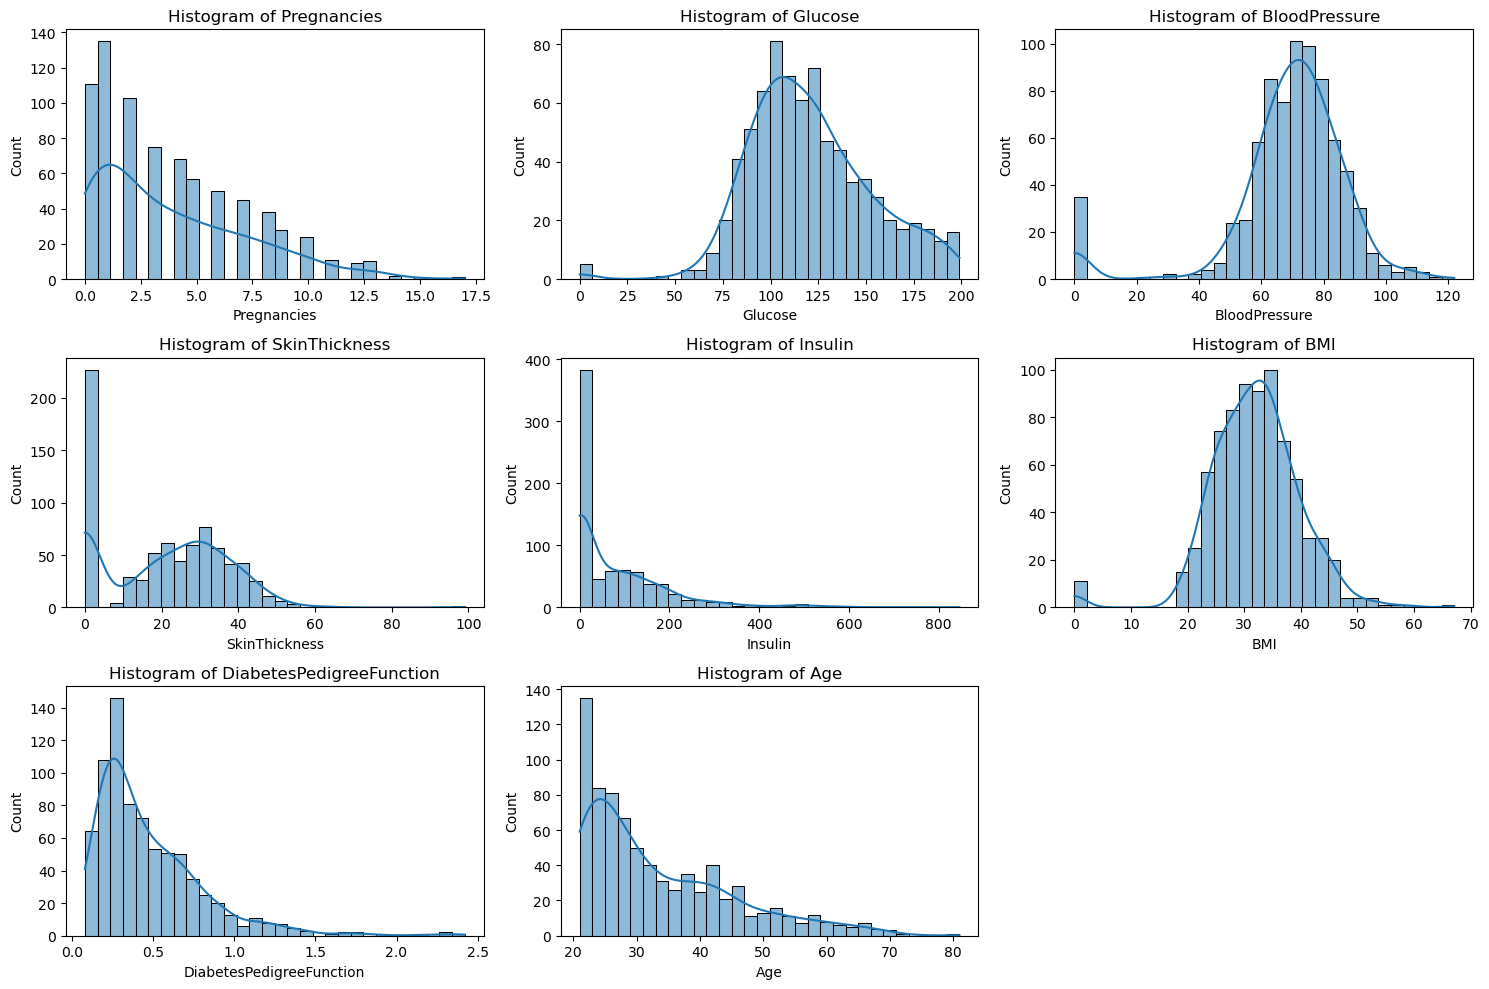

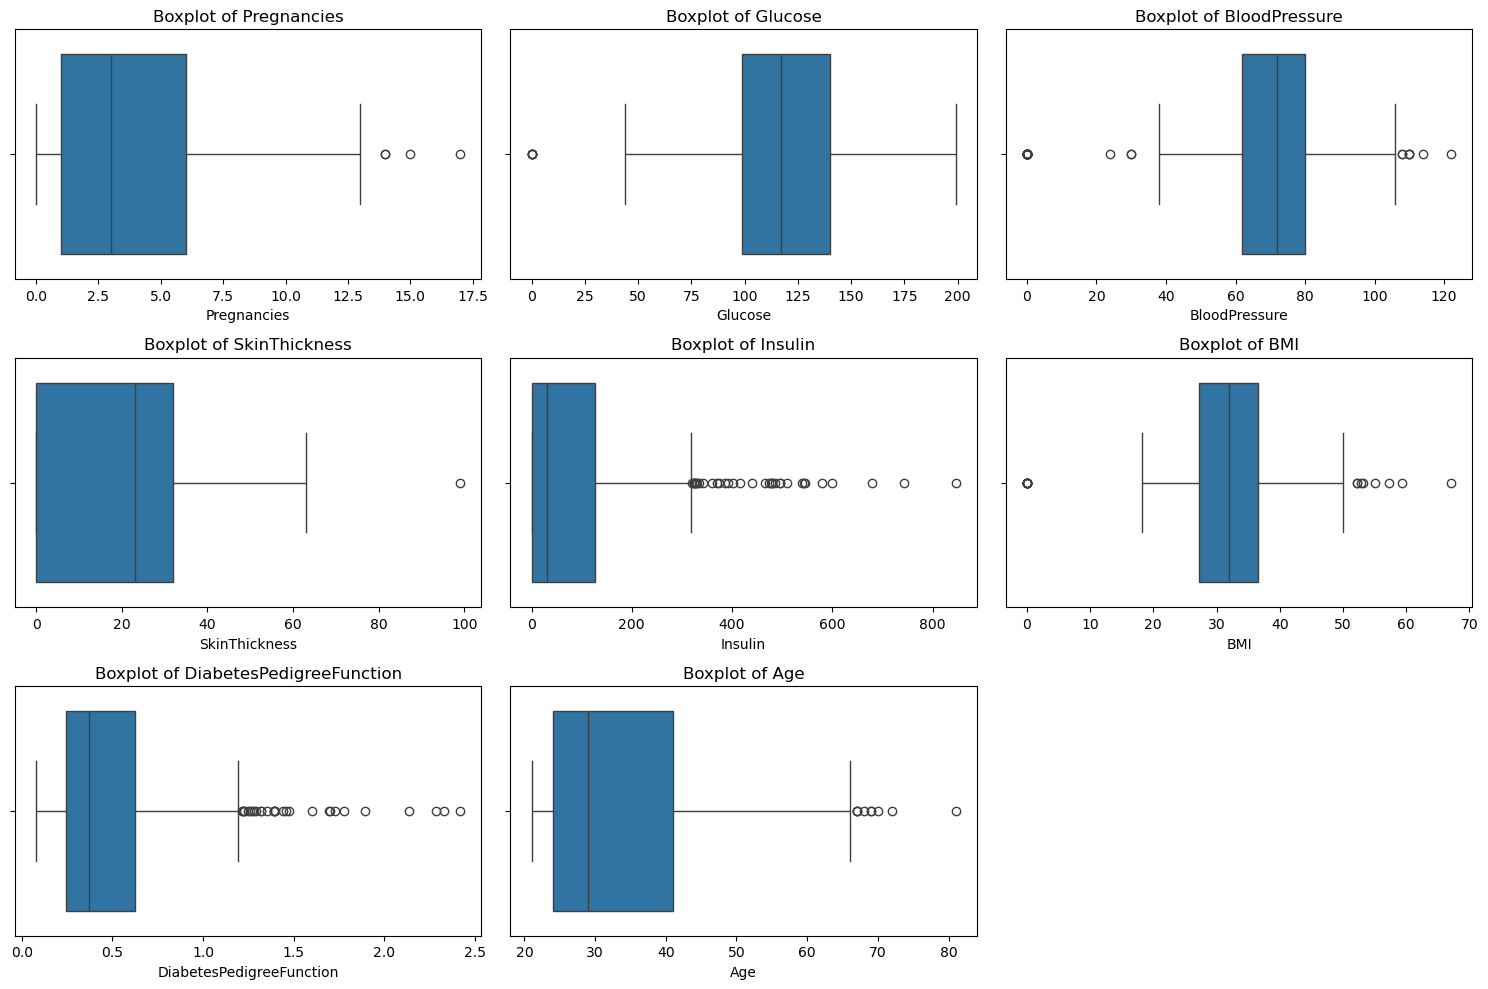

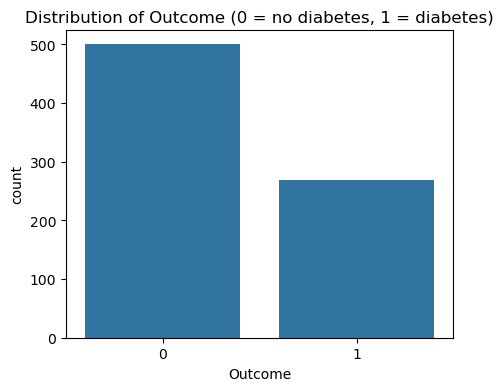

In [19]:
import matplotlib.pyplot as plt
import seaborn as sns

# Select feature columns (exclude Outcome for now)
features = Diabet.columns.drop("Outcome")

# Histograms
plt.figure(figsize=(15, 10))
for i, col in enumerate(features, 1):
    plt.subplot(3, 3, i)
    sns.histplot(Diabet[col], bins=30, kde=True)
    plt.title(f"Histogram of {col}")
plt.tight_layout()
plt.show()

# Boxplots
plt.figure(figsize=(15, 10))
for i, col in enumerate(features, 1):
    plt.subplot(3, 3, i)
    sns.boxplot(x=Diabet[col])
    plt.title(f"Boxplot of {col}")
plt.tight_layout()
plt.show()

# Outcome distribution
plt.figure(figsize=(5, 4))
sns.countplot(x="Outcome", data=Diabet)
plt.title("Distribution of Outcome (0 = no diabetes, 1 = diabetes)")
plt.show()


### Noise Detection

In [21]:
# Columns where 0 should be considered missing
cols_with_missing = ["Glucose", "BloodPressure", "SkinThickness", "Insulin", "BMI"]

# Replace 0 with NaN
Diabet[cols_with_missing] = Diabet[cols_with_missing].replace(0, np.nan)

# Check how many missing values we created
print(Diabet.isnull().sum())

Pregnancies                   0
Glucose                       5
BloodPressure                35
SkinThickness               227
Insulin                     374
BMI                          11
DiabetesPedigreeFunction      0
Age                           0
Outcome                       0
dtype: int64


### 80/20 split Data

In [23]:
from sklearn.model_selection import train_test_split

# Features and target
X = Diabet.drop("Outcome", axis=1)
y = Diabet["Outcome"]

# Train-test split (80/20)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print("Train shape:", X_train.shape, y_train.shape)
print("Test shape:", X_test.shape, y_test.shape)


Train shape: (614, 8) (614,)
Test shape: (154, 8) (154,)


### Missing values

In [25]:
# Count missing values in training data
print("Missing values in training set:")
print(X_train.isnull().sum())

Missing values in training set:
Pregnancies                   0
Glucose                       4
BloodPressure                23
SkinThickness               175
Insulin                     290
BMI                           9
DiabetesPedigreeFunction      0
Age                           0
dtype: int64


Glucose (4 missing) → very few, but Glucose is the most important clinical measure for diabetes → cannot just drop.

BloodPressure (23 missing) → still manageable but meaningful.

SkinThickness (175 missing, ~28% of train) → a lot missing, might be unreliable.

Insulin (290 missing, ~47% of train) → almost half missing, very risky.

BMI (9 missing) → important metabolic measure, easy to impute.

Pregnancies, DPF, Age → complete, no action needed.

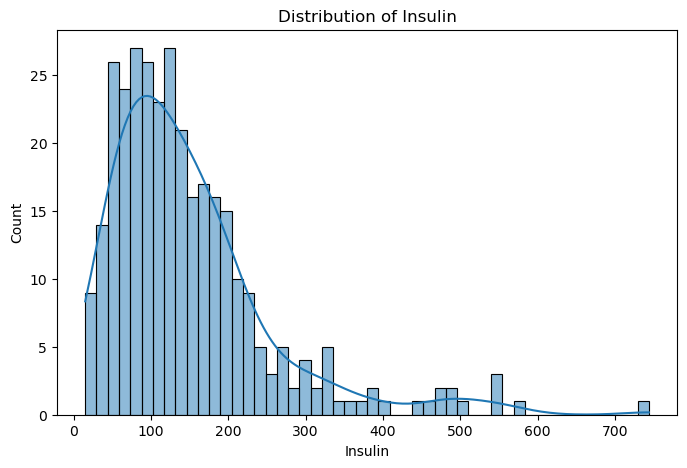

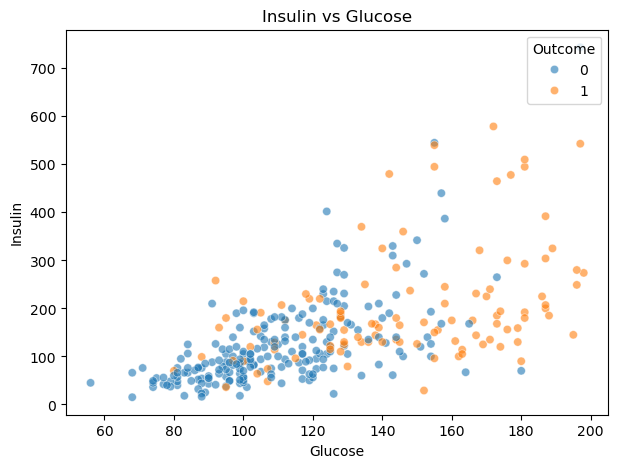

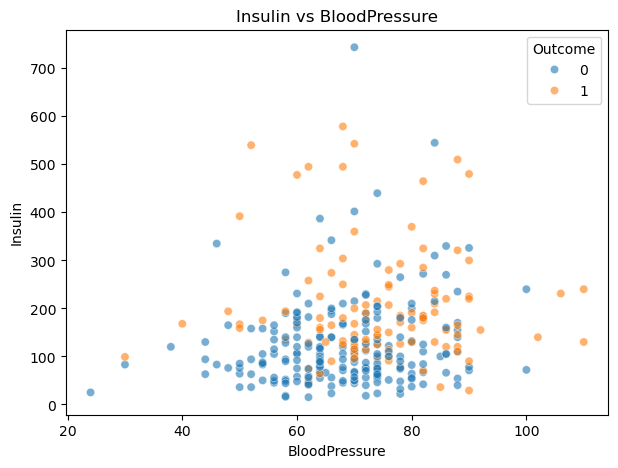

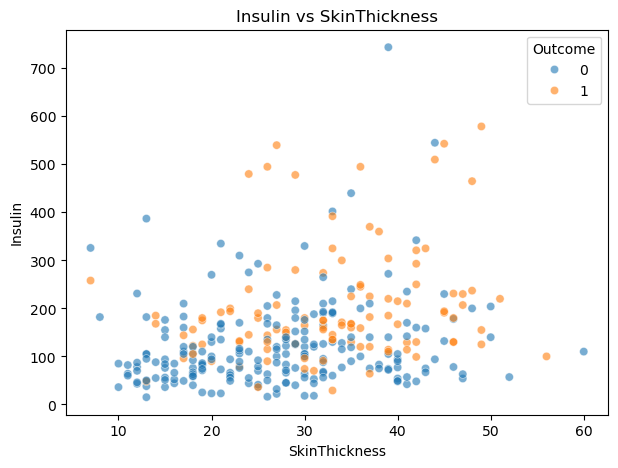

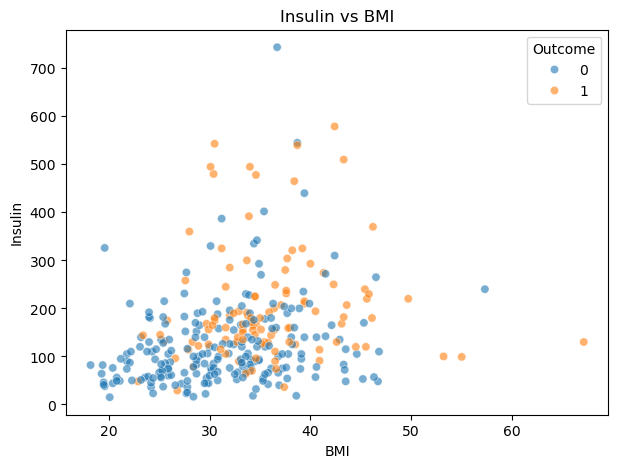

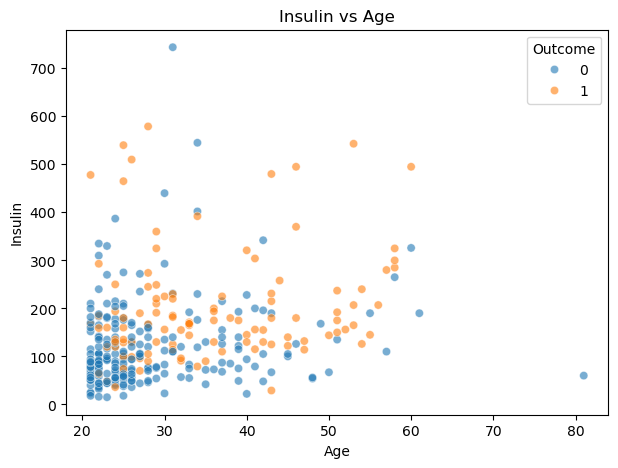

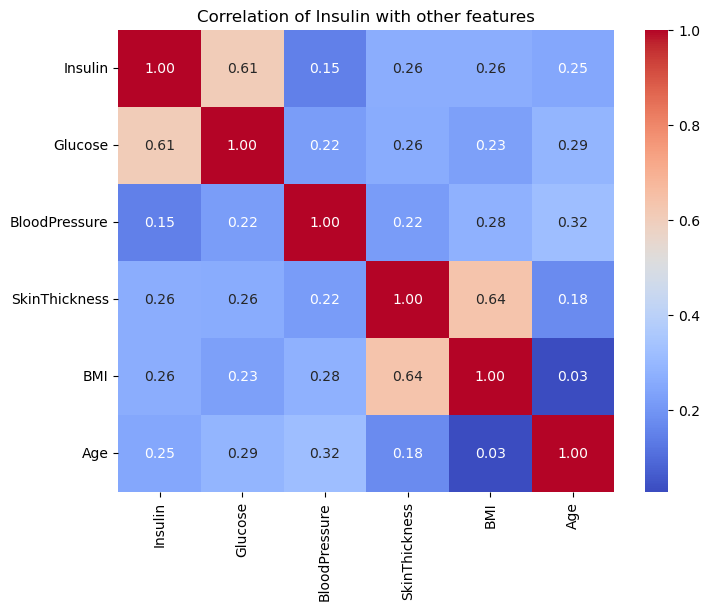

In [28]:
# Distribution of Insulin
plt.figure(figsize=(8,5))
sns.histplot(X_train["Insulin"].dropna(), bins=50, kde=True)
plt.title("Distribution of Insulin")
plt.xlabel("Insulin")
plt.ylabel("Count")
plt.show()

# Pairwise relationship with other numeric features
for col in ["Glucose", "BloodPressure", "SkinThickness", "BMI", "Age"]:
    plt.figure(figsize=(7,5))
    sns.scatterplot(x=X_train[col], y=X_train["Insulin"], hue=y_train, alpha=0.6)
    plt.title(f"Insulin vs {col}")
    plt.xlabel(col)
    plt.ylabel("Insulin")
    plt.legend(title="Outcome", loc="upper right")
    plt.show()

# Correlation heatmap including Insulin
plt.figure(figsize=(8,6))
corr = X_train[["Insulin","Glucose","BloodPressure","SkinThickness","BMI","Age"]].corr()
sns.heatmap(corr, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation of Insulin with other features")
plt.show()

In [30]:
from sklearn.impute import KNNImputer
import numpy as np

# ---- 1. Median imputation for BMI, Glucose, BloodPressure ----
for col in ["BMI", "Glucose", "BloodPressure"]:
    median_val = X_train[col].median()
    X_train[col].fillna(median_val, inplace=True)

# ---- 2. KNN imputation for SkinThickness (exclude Insulin to avoid bias) ----
knn_st = KNNImputer(n_neighbors=5)
cols_st = [c for c in X_train.columns if c != "Insulin"]  # exclude Insulin
X_train[cols_st] = knn_st.fit_transform(X_train[cols_st])

# ---- 3. KNN imputation for Insulin (now include all features) ----
knn_all = KNNImputer(n_neighbors=5)
X_train[:] = knn_all.fit_transform(X_train)

# ---- 4. Check remaining missing values ----
print("Remaining missing values:\n", X_train.isnull().sum())


Remaining missing values:
 Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
dtype: int64


C:\Users\Administrator\AppData\Local\Temp\ipykernel_1836\72361170.py:7: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  X_train[col].fillna(median_val, inplace=True)


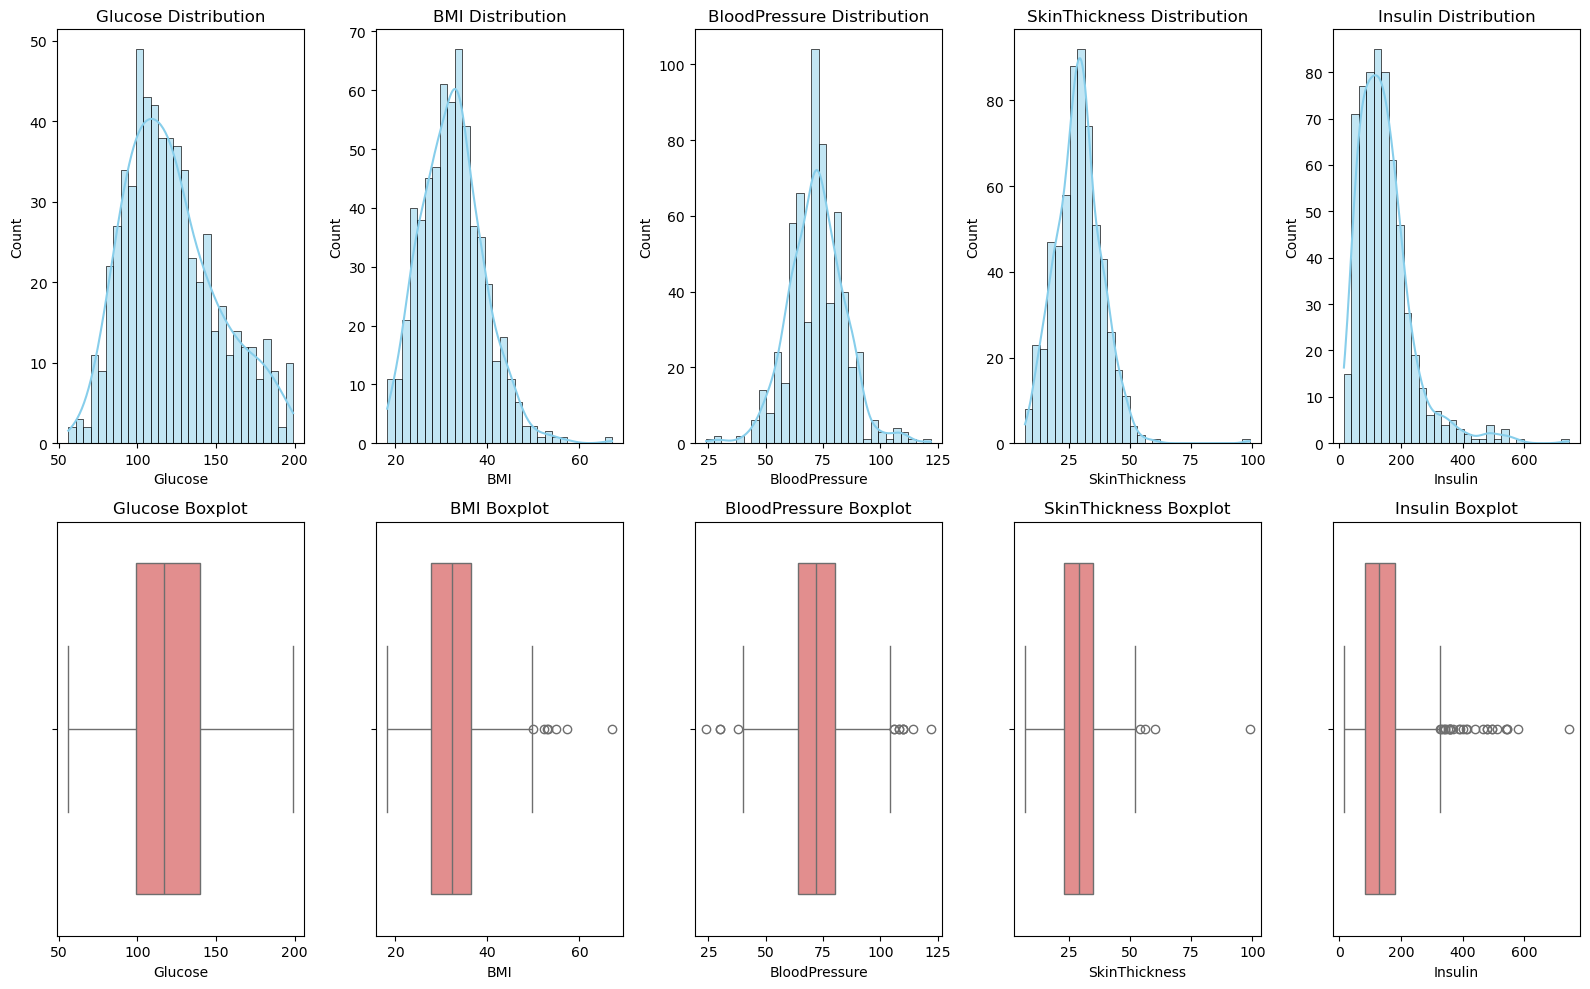

In [32]:
import matplotlib.pyplot as plt
import seaborn as sns

# List of medical features to check
features = ["Glucose", "BMI", "BloodPressure", "SkinThickness", "Insulin"]

plt.figure(figsize=(16, 10))

for i, col in enumerate(features, 1):
    plt.subplot(2, 5, i)  # histogram
    sns.histplot(X_train[col], kde=True, bins=30, color="skyblue")
    plt.title(f"{col} Distribution")
    
    plt.subplot(2, 5, i+5)  # boxplot
    sns.boxplot(x=X_train[col], color="lightcoral")
    plt.title(f"{col} Boxplot")

plt.tight_layout()
plt.show()


### OUTLIER Handling
Detect outliers with IQR

In [34]:
import pandas as pd

# Select numeric columns you want to check for outliers
cols_to_check = ["Glucose", "BloodPressure", "SkinThickness", "Insulin", "BMI"]

# Function to detect outliers using IQR
def detect_outliers_iqr(df, columns):
    outlier_index = []
    
    for col in columns:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower = Q1 - 1.5 * IQR
        upper = Q3 + 1.5 * IQR
        
        outliers = df[(df[col] < lower) | (df[col] > upper)].index
        outlier_index.extend(outliers)
    
    # unique indices of outliers
    outlier_index = list(set(outlier_index))
    return outlier_index

# Detect outliers in training set
outlier_idx = detect_outliers_iqr(X_train, cols_to_check)

# Split into clean and outlier sets
X_train_outliers = X_train.loc[outlier_idx]
y_train_outliers = y_train.loc[outlier_idx]

X_train_clean = X_train.drop(outlier_idx)
y_train_clean = y_train.drop(outlier_idx)

# Test set remains unchanged
X_test_clean = X_test.copy()
y_test_clean = y_test.copy()

print("Training set size (clean):", X_train_clean.shape)
print("Outliers detected:", X_train_outliers.shape)
print("Test set size:", X_test_clean.shape)


Training set size (clean): (566, 8)
Outliers detected: (48, 8)
Test set size: (154, 8)


### missing data of Test Datas:
according to what i did on train data

In [38]:
from sklearn.impute import SimpleImputer
# -----------------------------
# 1. Median Imputer for selected columns
# -----------------------------
median_cols = ["Glucose", "BloodPressure", "BMI"]

median_imputer = SimpleImputer(strategy="median")
median_imputer.fit(X_train_clean[median_cols])   # fit only on train

X_train_clean[median_cols] = median_imputer.transform(X_train_clean[median_cols])
X_test_clean[median_cols]  = median_imputer.transform(X_test_clean[median_cols])

# -----------------------------
# 2. KNN Imputer for SkinThickness (without Insulin)
# -----------------------------
knn_skin = KNNImputer(n_neighbors=5)
skin_cols = ["Pregnancies","Glucose","BloodPressure","BMI",
             "DiabetesPedigreeFunction","Age","SkinThickness"]

knn_skin.fit(X_train_clean[skin_cols])  # fit only on train

X_train_clean[skin_cols] = knn_skin.transform(X_train_clean[skin_cols])
X_test_clean[skin_cols]  = knn_skin.transform(X_test_clean[skin_cols])

# -----------------------------
# 3. KNN Imputer for Insulin (with all columns)
# -----------------------------
knn_all = KNNImputer(n_neighbors=5)
knn_all.fit(X_train_clean)   # fit on full train

X_train_clean = pd.DataFrame(knn_all.transform(X_train_clean), columns=X_train_clean.columns)
X_test_clean  = pd.DataFrame(knn_all.transform(X_test_clean),  columns=X_test_clean.columns)

# -----------------------------
# Now check missing values again
# -----------------------------
print("Train missing values:\n", X_train_clean.isnull().sum())
print("Test missing values:\n", X_test_clean.isnull().sum())


Train missing values:
 Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
dtype: int64
Test missing values:
 Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
dtype: int64


# Train
X_train_scaled, y_train_clean

# Test
X_test_scaled, y_test_clean


### Scaling

In [43]:
from sklearn.preprocessing import StandardScaler

# Initialize scaler
scaler = StandardScaler()

# Fit ONLY on train_clean
scaler.fit(X_train_clean)

# Transform train and test
X_train_scaled = scaler.transform(X_train_clean)
X_test_scaled  = scaler.transform(X_test_clean)

# If you want DataFrame output with column names:
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train_clean.columns, index=X_train_clean.index)
X_test_scaled  = pd.DataFrame(X_test_scaled,  columns=X_test_clean.columns,  index=X_test_clean.index)


In [45]:
### check datas
# Check for missing values
print("Missing values in X_train_scaled:\n", X_train_scaled.isnull().sum())
print("Missing values in X_test_scaled:\n", X_test_scaled.isnull().sum())

# Check shapes
print("\nShapes:")
print("X_train_scaled:", X_train_scaled.shape)
print("y_train_clean:  ", y_train_clean.shape)
print("X_test_scaled:  ", X_test_scaled.shape)
print("y_test_clean:   ", y_test_clean.shape)

# Check if indices match for train
if len(X_train_scaled) == len(y_train_clean):
    print("\n✅ Train X and Y lengths match")
else:
    print("\n❌ Train X and Y lengths DO NOT match!")

# Check if indices match for test
if len(X_test_scaled) == len(y_test_clean):
    print("✅ Test X and Y lengths match")
else:
    print("❌ Test X and Y lengths DO NOT match!")



Missing values in X_train_scaled:
 Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
dtype: int64
Missing values in X_test_scaled:
 Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
dtype: int64

Shapes:
X_train_scaled: (566, 8)
y_train_clean:   (566,)
X_test_scaled:   (154, 8)
y_test_clean:    (154,)

✅ Train X and Y lengths match
✅ Test X and Y lengths match


# Step2:
### Model Selection

### Logistic Regression

Fitting 5 folds for each of 32 candidates, totalling 160 fits
Best params: {'C': 10, 'penalty': 'l1', 'solver': 'liblinear'}
Best CV F1 (from GridSearch): 0.6349846390168971
Saved Logistic Regression model as 'logreg_best.pkl'
Cross-val F1 (5-fold) mean: 0.6350  std: 0.0354

--- Performance ---
Train Accuracy: 0.7968197879858657
Test Accuracy:  0.7077922077922078
Train F1:       0.6504559270516718
Test F1:        0.5714285714285714

Classification Report (Test):
               precision    recall  f1-score   support

           0       0.77      0.79      0.78       100
           1       0.59      0.56      0.57        54

    accuracy                           0.71       154
   macro avg       0.68      0.67      0.67       154
weighted avg       0.70      0.71      0.71       154

Confusion Matrix (Test):
 [[79 21]
 [24 30]]
Test ROC-AUC:   0.8109259259259259

Logistic coefficients (sorted):
BloodPressure               0.051364
Insulin                     0.085847
Age               

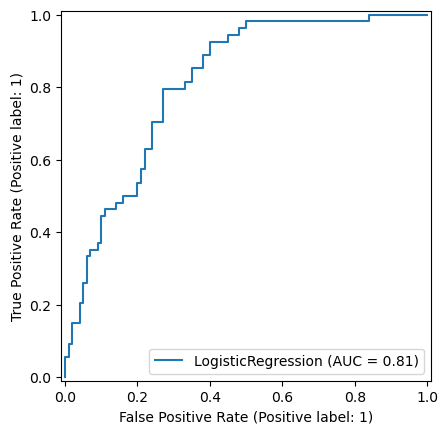

In [127]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
import joblib

# -----------------------------
# 1) Define Logistic Regression estimator
# -----------------------------
logreg = LogisticRegression(random_state=42, max_iter=5000)

# -----------------------------
# 2) Valid param grid to avoid incompatible solver/penalty combos
# -----------------------------
param_grid = [
    # liblinear supports l1 and l2
    {
        "solver": ["liblinear"],
        "penalty": ["l1", "l2"],
        "C": [0.01, 0.1, 1, 10]
    },
    # lbfgs supports l2
    {
        "solver": ["lbfgs"],
        "penalty": ["l2"],
        "C": [0.01, 0.1, 1, 10]
    },
    # saga supports l1, l2
    {
        "solver": ["saga"],
        "penalty": ["l1", "l2"],
        "C": [0.01, 0.1, 1, 10]
    },
    # saga + elasticnet requires l1_ratio
    {
        "solver": ["saga"],
        "penalty": ["elasticnet"],
        "C": [0.01, 0.1, 1, 10],
        "l1_ratio": [0.1, 0.5, 0.9]
    }
]

# -----------------------------
# 3) GridSearchCV
# -----------------------------
grid = GridSearchCV(
    estimator=logreg,
    param_grid=param_grid,
    cv=5,
    scoring="f1",
    n_jobs=-1,
    verbose=1,
    error_score=np.nan
)

grid.fit(X_train_scaled, y_train_clean)

# -----------------------------
# 4) Best estimator & CV result
# -----------------------------
best_log = grid.best_estimator_
print("Best params:", grid.best_params_)
print("Best CV F1 (from GridSearch):", grid.best_score_)

# Save the model
import joblib
joblib.dump(best_log, "logreg_best.pkl")
print("Saved Logistic Regression model as 'logreg_best.pkl'")

# Optional: cross-val F1 on train
cv_scores = cross_val_score(best_log, X_train_scaled, y_train_clean, cv=5, scoring="f1")
print("Cross-val F1 (5-fold) mean: {:.4f}  std: {:.4f}".format(cv_scores.mean(), cv_scores.std()))

# -----------------------------
# 5) Predictions & metrics on train and test
# -----------------------------
y_train_pred = best_log.predict(X_train_scaled)
y_test_pred  = best_log.predict(X_test_scaled)

train_acc = accuracy_score(y_train_clean, y_train_pred)
test_acc  = accuracy_score(y_test_clean, y_test_pred)
train_f1  = f1_score(y_train_clean, y_train_pred)
test_f1   = f1_score(y_test_clean, y_test_pred)

print("\n--- Performance ---")
print("Train Accuracy:", train_acc)
print("Test Accuracy: ", test_acc)
print("Train F1:      ", train_f1)
print("Test F1:       ", test_f1)

# -----------------------------
# 6) Classification report + confusion matrix
# -----------------------------
print("\nClassification Report (Test):\n", classification_report(y_test_clean, y_test_pred))
cm = confusion_matrix(y_test_clean, y_test_pred)
print("Confusion Matrix (Test):\n", cm)

# Optional: ROC-AUC using predicted probabilities
from sklearn.metrics import roc_auc_score, RocCurveDisplay
if hasattr(best_log, "predict_proba"):
    y_test_proba = best_log.predict_proba(X_test_scaled)[:, 1]
    roc_auc = roc_auc_score(y_test_clean, y_test_proba)
    print("Test ROC-AUC:  ", roc_auc)
    RocCurveDisplay.from_estimator(best_log, X_test_scaled, y_test_clean)
else:
    print("Model has no predict_proba; skipping ROC-AUC")

# -----------------------------
# 7) Feature coefficients
# -----------------------------
coefs = pd.Series(best_log.coef_.ravel(), index=X_train_scaled.columns)
print("\nLogistic coefficients (sorted):")
print(coefs.sort_values())

# -----------------------------
# 8) Summary table
# -----------------------------
results_table = pd.DataFrame([
    {"Dataset": "Train", "Accuracy": train_acc, "F1": train_f1},
    {"Dataset": "Test",  "Accuracy": test_acc,  "F1": test_f1}
])

print("\n📊 Logistic Regression Results:")
print(results_table)


### DecisionTreeClassifier

Fitting 5 folds for each of 160 candidates, totalling 800 fits
Best params: {'criterion': 'gini', 'max_depth': 7, 'min_samples_leaf': 2, 'min_samples_split': 10}
Best CV F1: 0.626984628538503

--- Performance ---
Train Accuracy: 0.8675
Test Accuracy:  0.6948
Train F1:       0.8021
Test F1:        0.5347

Classification Report (Test):
              precision    recall  f1-score   support

           0       0.75      0.80      0.77       100
           1       0.57      0.50      0.53        54

    accuracy                           0.69       154
   macro avg       0.66      0.65      0.65       154
weighted avg       0.69      0.69      0.69       154

Confusion Matrix (Test):
 [[80 20]
 [27 27]]
Test ROC-AUC:   0.7156481481481481

Feature Importances:
Glucose                     0.317489
Insulin                     0.200955
BMI                         0.184867
DiabetesPedigreeFunction    0.116153
Age                         0.076850
BloodPressure               0.048835
Pregnancies  

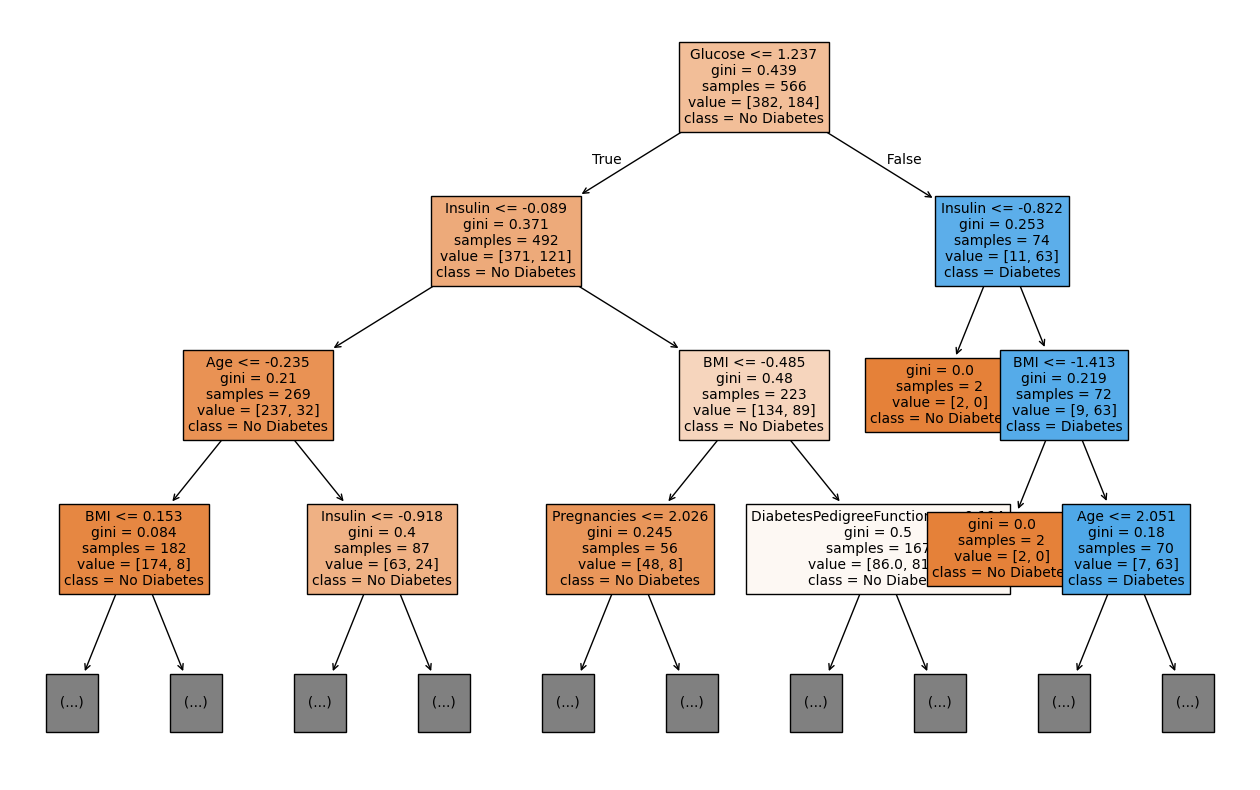

Saved best Decision Tree to dt_best.pkl


In [136]:
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix, roc_auc_score
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
import pandas as pd
import joblib

# -------------------------
# 1) Decision Tree with GridSearch ----------------------------------------------------------------------------------------------
# -------------------------
dtree = DecisionTreeClassifier(random_state=42)

# Hyperparameter grid
param_grid = {
    "max_depth": [3, 5, 7, 10, None],
    "min_samples_split": [2, 5, 10, 20],
    "min_samples_leaf": [1, 2, 5, 10],
    "criterion": ["gini", "entropy"]
}

grid_dt = GridSearchCV(dtree, param_grid, cv=5, scoring="f1", n_jobs=-1, verbose=1)
grid_dt.fit(X_train_scaled, y_train_clean)

best_dt = grid_dt.best_estimator_
print("Best params:", grid_dt.best_params_)
print("Best CV F1:", grid_dt.best_score_)

# -------------------------
# 2) Predictions & Evaluation ----------------------------------------------------------------------------------------------
# -------------------------
y_train_pred = best_dt.predict(X_train_scaled)
y_test_pred  = best_dt.predict(X_test_scaled)

train_acc = accuracy_score(y_train_clean, y_train_pred)
test_acc  = accuracy_score(y_test_clean, y_test_pred)
train_f1  = f1_score(y_train_clean, y_train_pred)
test_f1   = f1_score(y_test_clean, y_test_pred)

print("\n--- Performance ---")
print(f"Train Accuracy: {train_acc:.4f}")
print(f"Test Accuracy:  {test_acc:.4f}")
print(f"Train F1:       {train_f1:.4f}")
print(f"Test F1:        {test_f1:.4f}")

print("\nClassification Report (Test):")
print(classification_report(y_test_clean, y_test_pred))

print("Confusion Matrix (Test):\n", confusion_matrix(y_test_clean, y_test_pred))
print("Test ROC-AUC:  ", roc_auc_score(y_test_clean, best_dt.predict_proba(X_test_scaled)[:,1]))

# -------------------------
# 3) Feature importance --------------------------------------------------------------------------------------------------
# -------------------------
feat_importances = pd.Series(best_dt.feature_importances_, index=X_train_scaled.columns)
print("\nFeature Importances:")
print(feat_importances.sort_values(ascending=False))

# -------------------------
# 4) (Optional) Visualize the Tree
# -------------------------
plt.figure(figsize=(16, 10))
plot_tree(best_dt, feature_names=X_train_scaled.columns, class_names=["No Diabetes", "Diabetes"],
          filled=True, max_depth=3, fontsize=10)
plt.show()

# -------------------------
# 5) Save the best Decision Tree for later use
# -------------------------
joblib.dump(best_dt, "dt_best.pkl")
print("Saved best Decision Tree to dt_best.pkl")

### Random Forest

In [100]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix, roc_auc_score
import numpy as np, pandas as pd, joblib

# estimator
rf = RandomForestClassifier(random_state=42, n_jobs=-1)

# wide search space
param_dist = {
    "n_estimators": [100, 200, 300, 500, 800,900],
    "max_depth": [None,3, 5, 8, 12, 16, 20],
    "min_samples_split": [2, 5, 8, 12],
    "min_samples_leaf": [1, 2, 4, 6],
    "max_features": ["sqrt", "log2", 0.5, 0.7,0.8,1],
    "criterion": ["gini", "entropy"],
    "bootstrap": [True, False],
    "class_weight": [None, "balanced"]
}

rs = RandomizedSearchCV(
    estimator=rf,
    param_distributions=param_dist,
    n_iter=60,               # try 60 random combos (adjust based on compute)
    cv=5,
    scoring="f1",
    n_jobs=-1,
    verbose=2,
    random_state=42
)

rs.fit(X_train_scaled, y_train_clean)

best_rf = rs.best_estimator_
print("Best params (Randomized):", rs.best_params_)
print("Best CV F1 (Randomized):", rs.best_score_)

# Evaluate
y_train_pred = best_rf.predict(X_train_scaled)
y_test_pred  = best_rf.predict(X_test_scaled)
y_test_proba = best_rf.predict_proba(X_test_scaled)[:,1]

print("Train Acc:", accuracy_score(y_train_clean, y_train_pred))
print("Test  Acc:", accuracy_score(y_test_clean, y_test_pred))
print("Train F1 :", f1_score(y_train_clean, y_train_pred))
print("Test F1  :", f1_score(y_test_clean, y_test_pred))
print("Test ROC-AUC:", roc_auc_score(y_test_clean, y_test_proba))

print("\nClassification Report (Test):\n", classification_report(y_test_clean, y_test_pred))
print("Confusion Matrix (Test):\n", confusion_matrix(y_test_clean, y_test_pred))

# Feature importances
feat_imp = pd.Series(best_rf.feature_importances_, index=X_train_scaled.columns).sort_values(ascending=False)
print("\nTop features:\n", feat_imp.head(10))

# Save model
joblib.dump(best_rf, "rf_best_randomized.pkl")
print("Saved Randomized best rf to rf_best_randomized.pkl")


Fitting 5 folds for each of 60 candidates, totalling 300 fits
Best params (Randomized): {'n_estimators': 500, 'min_samples_split': 8, 'min_samples_leaf': 1, 'max_features': 0.5, 'max_depth': 5, 'criterion': 'gini', 'class_weight': 'balanced', 'bootstrap': False}
Best CV F1 (Randomized): 0.6705288387301349
Train Acc: 0.8533568904593639
Test  Acc: 0.7467532467532467
Train F1 : 0.8056206088992974
Test F1  : 0.6929133858267716
Test ROC-AUC: 0.822037037037037

Classification Report (Test):
               precision    recall  f1-score   support

           0       0.88      0.71      0.78       100
           1       0.60      0.81      0.69        54

    accuracy                           0.75       154
   macro avg       0.74      0.76      0.74       154
weighted avg       0.78      0.75      0.75       154

Confusion Matrix (Test):
 [[71 29]
 [10 44]]

Top features:
 Glucose                     0.333167
Insulin                     0.222540
BMI                         0.153091
Age       

### XGBoost (XGBClassifier)

Fitting 5 folds for each of 50 candidates, totalling 250 fits


C:\ProgramData\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [14:17:43] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



Best params (Randomized XGBoost): {'subsample': 1.0, 'reg_lambda': 2, 'reg_alpha': 0.1, 'n_estimators': 600, 'min_child_weight': 5, 'max_depth': 6, 'learning_rate': 0.01, 'gamma': 0.2, 'colsample_bytree': 1.0}
Best CV F1 (Randomized): 0.627020072552215

--- Metrics ---
Train Acc: 0.9081272084805654
Test  Acc: 0.7272727272727273
Train F1 : 0.8522727272727273
Test F1  : 0.6111111111111112
Test ROC-AUC: 0.8088888888888889

Classification Report (Test):
               precision    recall  f1-score   support

           0       0.79      0.79      0.79       100
           1       0.61      0.61      0.61        54

    accuracy                           0.73       154
   macro avg       0.70      0.70      0.70       154
weighted avg       0.73      0.73      0.73       154

Confusion Matrix (Test):
 [[79 21]
 [21 33]]

Top feature importances (gain):
 Glucose                     7.451412
Insulin                     4.221427
BMI                         3.387811
Age                        

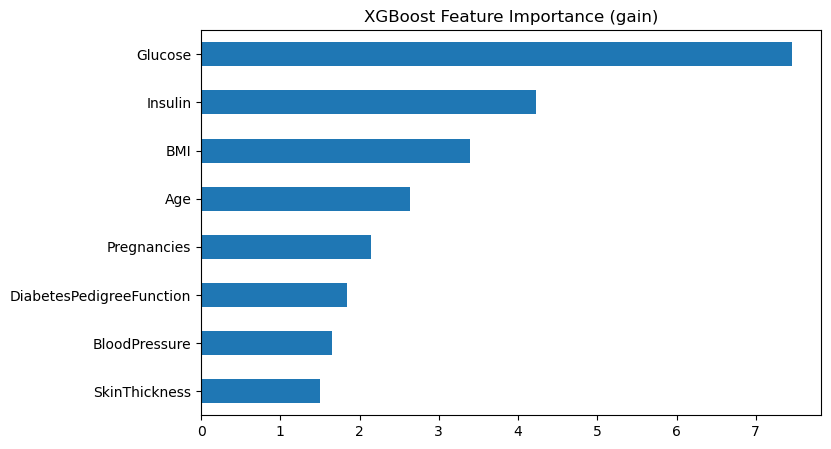

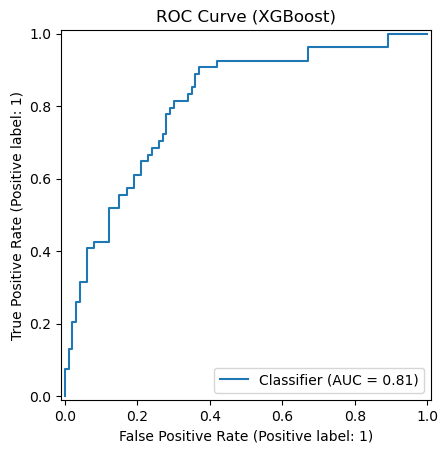

Saved best XGBoost to xgb_best_randomized.pkl


In [82]:
# XGBoost with RandomizedSearchCV (tuned for F1)
import joblib
import matplotlib.pyplot as plt

from xgboost import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import (
    accuracy_score, f1_score, classification_report,
    confusion_matrix, roc_auc_score, RocCurveDisplay
)

# ----------------------------
# 1) Estimator
# ----------------------------
xgb = XGBClassifier(
    objective='binary:logistic',
    use_label_encoder=False,
    eval_metric='logloss',
    random_state=42,
    n_jobs=-1
)

# ----------------------------
# 2) Hyperparameter search space (reasonable, not gigantic)
# ----------------------------
param_dist = {
    "n_estimators": [100, 200, 400, 600, 800],
    "learning_rate": [0.01, 0.02, 0.05, 0.08, 0.1],
    "max_depth": [3, 4, 5, 6, 8],
    "subsample": [0.6, 0.7, 0.8, 0.9, 1.0],
    "colsample_bytree": [0.4, 0.6, 0.8, 1.0],
    "gamma": [0, 0.1, 0.2, 0.5],
    "min_child_weight": [1, 3, 5, 7],
    "reg_alpha": [0, 0.01, 0.1, 1],
    "reg_lambda": [0.5, 1, 2, 5],
    # you can include scale_pos_weight if you want, but we used class_weight in RF;
    # for XGBoost you can tune scale_pos_weight = sum(neg)/sum(pos) optionally
}

# ----------------------------
# 3) RandomizedSearchCV
# ----------------------------
rs = RandomizedSearchCV(
    estimator=xgb,
    param_distributions=param_dist,
    n_iter=50,           # try 50 random combos (change if you have more time)
    scoring="f1",
    cv=5,
    n_jobs=-1,
    verbose=2,
    random_state=42
)

rs.fit(X_train_scaled, y_train_clean)

best_xgb = rs.best_estimator_
print("\nBest params (Randomized XGBoost):", rs.best_params_)
print("Best CV F1 (Randomized):", rs.best_score_)

# ----------------------------
# 4) Evaluate on train & test
# ----------------------------
y_train_pred = best_xgb.predict(X_train_scaled)
y_test_pred  = best_xgb.predict(X_test_scaled)

y_test_proba = best_xgb.predict_proba(X_test_scaled)[:, 1] if hasattr(best_xgb, "predict_proba") else None

print("\n--- Metrics ---")
print("Train Acc:", accuracy_score(y_train_clean, y_train_pred))
print("Test  Acc:", accuracy_score(y_test_clean, y_test_pred))
print("Train F1 :", f1_score(y_train_clean, y_train_pred))
print("Test F1  :", f1_score(y_test_clean, y_test_pred))

if y_test_proba is not None:
    print("Test ROC-AUC:", roc_auc_score(y_test_clean, y_test_proba))

print("\nClassification Report (Test):\n", classification_report(y_test_clean, y_test_pred))
print("Confusion Matrix (Test):\n", confusion_matrix(y_test_clean, y_test_pred))

# ----------------------------
# 5) Feature importance (gain) and plot
# ----------------------------
try:
    fi = pd.Series(best_xgb.get_booster().get_score(importance_type="gain"))
    # get_score keys are "f0","f1"... map to column names
    # Convert to readable series:
    fmap = {f"f{i}": col for i, col in enumerate(X_train_scaled.columns)}
    fi.index = fi.index.map(lambda k: fmap.get(k, k))
    fi = fi.sort_values(ascending=False)
    print("\nTop feature importances (gain):\n", fi.head(10))

    # Plot top 10
    plt.figure(figsize=(8,5))
    fi.head(10).plot(kind="barh")
    plt.gca().invert_yaxis()
    plt.title("XGBoost Feature Importance (gain)")
    plt.show()
except Exception as e:
    print("Could not plot feature importances:", e)

# ----------------------------
# 6) ROC curve
# ----------------------------
if y_test_proba is not None:
    RocCurveDisplay.from_predictions(y_test_clean, y_test_proba)
    plt.title("ROC Curve (XGBoost)")
    plt.show()

# ----------------------------
# 7) Save best model
# ----------------------------
joblib.dump(best_xgb, "xgb_best_randomized.pkl")
print("Saved best XGBoost to xgb_best_randomized.pkl")


### LightGBM (LGBMClassifier)

Fitting 5 folds for each of 50 candidates, totalling 250 fits
[LightGBM] [Info] Number of positive: 184, number of negative: 382
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000192 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 755
[LightGBM] [Info] Number of data points in the train set: 566, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[Lig

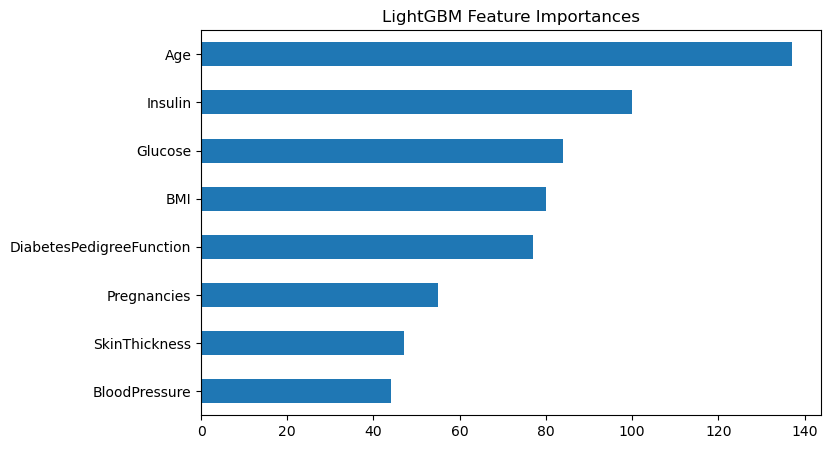

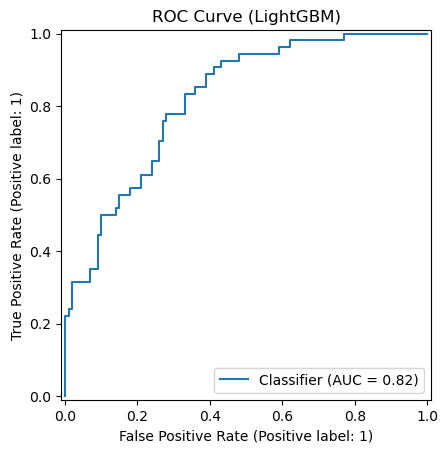

Saved best LightGBM to lgb_best_randomized.pkl


In [85]:
# LightGBM with RandomizedSearchCV
import joblib
from lightgbm import LGBMClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import (
    accuracy_score, f1_score, classification_report,
    confusion_matrix, roc_auc_score, RocCurveDisplay
)

# ---- 1) Estimator
lgb = LGBMClassifier(random_state=42, n_jobs=-1)

# ---- 2) Hyperparameter search space (reasonable & practical)
param_dist = {
    "n_estimators": [100, 200, 400, 600, 800],
    "learning_rate": [0.01, 0.02, 0.05, 0.08, 0.1],
    "num_leaves": [15, 31, 50, 80],            # controls complexity (2^depth)
    "max_depth": [-1, 3, 5, 7, 10],            # -1 = no limit
    "min_child_samples": [5, 10, 20, 30],
    "subsample": [0.6, 0.7, 0.8, 0.9, 1.0],    # row subsample
    "colsample_bytree": [0.4, 0.6, 0.8, 1.0],  # feature subsample
    "reg_alpha": [0, 0.01, 0.1, 1],
    "reg_lambda": [0.5, 1, 2, 5],
    # if you want class handling you can tune scale_pos_weight instead of class_weight
    "class_weight": [None, "balanced"]
}

# ---- 3) RandomizedSearchCV
rs = RandomizedSearchCV(
    estimator=lgb,
    param_distributions=param_dist,
    n_iter=50,          # increase if you have more time/compute
    scoring="f1",
    cv=5,
    n_jobs=-1,
    verbose=2,
    random_state=42
)

# Fit on the clean scaled train set (important)
rs.fit(X_train_scaled, y_train_clean)

best_lgb = rs.best_estimator_
print("\nBest params (Randomized LightGBM):", rs.best_params_)
print("Best CV F1 (Randomized):", rs.best_score_)

# ---- 4) Evaluate on train & test
y_train_pred = best_lgb.predict(X_train_scaled)
y_test_pred  = best_lgb.predict(X_test_scaled)

# probs for ROC
if hasattr(best_lgb, "predict_proba"):
    y_test_proba = best_lgb.predict_proba(X_test_scaled)[:, 1]
else:
    y_test_proba = None

print("\n--- Metrics ---")
print("Train Acc:", accuracy_score(y_train_clean, y_train_pred))
print("Test  Acc:", accuracy_score(y_test_clean, y_test_pred))
print("Train F1 :", f1_score(y_train_clean, y_train_pred))
print("Test F1  :", f1_score(y_test_clean, y_test_pred))
if y_test_proba is not None:
    print("Test ROC-AUC:", roc_auc_score(y_test_clean, y_test_proba))

print("\nClassification Report (Test):\n", classification_report(y_test_clean, y_test_pred))
print("Confusion Matrix (Test):\n", confusion_matrix(y_test_clean, y_test_pred))

# ---- 5) Feature importance (gain) and plot
try:
    fi = pd.Series(best_lgb.feature_importances_, index=X_train_scaled.columns).sort_values(ascending=False)
    print("\nTop feature importances (split-based):\n", fi.head(10))

    plt.figure(figsize=(8,5))
    fi.head(10).plot(kind="barh")
    plt.gca().invert_yaxis()
    plt.title("LightGBM Feature Importances")
    plt.show()
except Exception as e:
    print("Could not plot feature importances:", e)

# ---- 6) ROC curve
if y_test_proba is not None:
    RocCurveDisplay.from_predictions(y_test_clean, y_test_proba)
    plt.title("ROC Curve (LightGBM)")
    plt.show()

# ---- 7) Save best model
joblib.dump(best_lgb, "lgb_best_randomized.pkl")
print("Saved best LightGBM to lgb_best_randomized.pkl")


### SVM (Support Vector Machine)

Fitting 5 folds for each of 66 candidates, totalling 330 fits
Best params: {'C': 0.1, 'class_weight': 'balanced', 'gamma': 0.1, 'kernel': 'rbf'}
Best CV F1 (GridSearch): 0.6639276904101141
Cross-val F1 (5-fold) mean: 0.6639  std: 0.0172

--- Performance ---
Train Accuracy: 0.7402826855123675
Test Accuracy:  0.6818181818181818
Train F1:       0.6740576496674058
Test F1:        0.6423357664233577
Test ROC-AUC:   0.7982407407407408


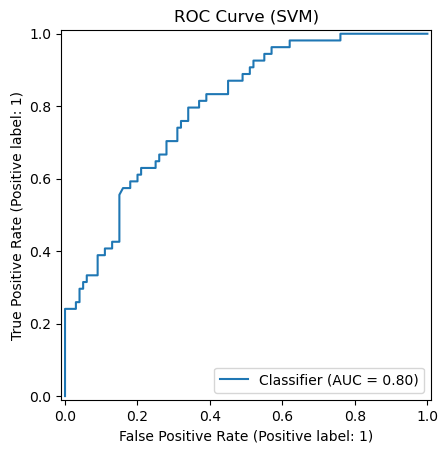


Classification Report (Test):
               precision    recall  f1-score   support

           0       0.86      0.61      0.71       100
           1       0.53      0.81      0.64        54

    accuracy                           0.68       154
   macro avg       0.69      0.71      0.68       154
weighted avg       0.74      0.68      0.69       154

Confusion Matrix (Test):
 [[61 39]
 [10 44]]

Number of support vectors for each class: [276 138]
Total support vectors: 414
Saved best SVM to 'svc_best.pkl'


In [112]:
# SVM (Support Vector Machine) — training + tuning + evaluation
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.metrics import (
    accuracy_score, f1_score, classification_report,
    confusion_matrix, roc_auc_score, RocCurveDisplay
)
import matplotlib.pyplot as plt
import joblib

# 1) Define base estimator (probability=True to allow ROC-AUC)
svc = SVC(probability=True, random_state=42)

# 2) Hyperparameter grid (not huge because SVM can be slow)
param_grid = [
    # linear kernel (fast)
    {"kernel": ["linear"], "C": [0.01, 0.1, 1, 10, 100], "class_weight": [None, "balanced"]},
    # rbf kernel (non-linear)
    {"kernel": ["rbf"], "C": [0.1, 1, 10, 50], "gamma": ["scale", 0.01, 0.1, 1], "class_weight": [None, "balanced"]},
    # poly kernel (optional, can be slower)
    {"kernel": ["poly"], "C": [0.1, 1, 10], "degree": [2, 3], "gamma": ["scale", 0.1], "class_weight": [None, "balanced"]}
]

# 3) GridSearchCV (5-fold) optimizing F1
grid = GridSearchCV(
    estimator=svc,
    param_grid=param_grid,
    scoring="f1",
    cv=5,
    n_jobs=-1,
    verbose=1,
    error_score=np.nan
)

grid.fit(X_train_scaled, y_train_clean)

best_svc = grid.best_estimator_
print("Best params:", grid.best_params_)
print("Best CV F1 (GridSearch):", grid.best_score_)

# 4) Cross-validation on best estimator
cv_scores = cross_val_score(best_svc, X_train_scaled, y_train_clean, cv=5, scoring="f1", n_jobs=-1)
print(f"Cross-val F1 (5-fold) mean: {cv_scores.mean():.4f}  std: {cv_scores.std():.4f}")

# 5) Fit best estimator on whole train set (already fitted by GridSearch but do it again to be explicit)
best_svc.fit(X_train_scaled, y_train_clean)

# 6) Predict & metrics
y_train_pred = best_svc.predict(X_train_scaled)
y_test_pred  = best_svc.predict(X_test_scaled)

train_acc = accuracy_score(y_train_clean, y_train_pred)
test_acc  = accuracy_score(y_test_clean, y_test_pred)
train_f1  = f1_score(y_train_clean, y_train_pred)
test_f1   = f1_score(y_test_clean, y_test_pred)

print("\n--- Performance ---")
print("Train Accuracy:", train_acc)
print("Test Accuracy: ", test_acc)
print("Train F1:      ", train_f1)
print("Test F1:       ", test_f1)

# 7) ROC-AUC
if hasattr(best_svc, "predict_proba"):
    y_test_proba = best_svc.predict_proba(X_test_scaled)[:, 1]
    print("Test ROC-AUC:  ", roc_auc_score(y_test_clean, y_test_proba))
    RocCurveDisplay.from_predictions(y_test_clean, y_test_proba)
    plt.title("ROC Curve (SVM)")
    plt.show()
else:
    print("SVC has no predict_proba; ROC-AUC skipped")

# 8) Classification report + confusion matrix
print("\nClassification Report (Test):\n", classification_report(y_test_clean, y_test_pred))
cm = confusion_matrix(y_test_clean, y_test_pred)
print("Confusion Matrix (Test):\n", cm)

# 9) Support vectors info (if available)
if hasattr(best_svc, "n_support_"):
    print("\nNumber of support vectors for each class:", best_svc.n_support_)
    print("Total support vectors:", sum(best_svc.n_support_))

# 10) Save model
joblib.dump(best_svc, "svc_best.pkl")
print("Saved best SVM to 'svc_best.pkl'")


### MLP

In [101]:
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import RandomizedSearchCV, cross_val_score
from sklearn.metrics import f1_score, accuracy_score, classification_report, confusion_matrix, roc_auc_score, RocCurveDisplay
import pandas as pd, numpy as np, joblib
import matplotlib.pyplot as plt

mlp = MLPClassifier(random_state=42, max_iter=10000)

param_dist = [
    {
        "solver": ["adam"],
        "hidden_layer_sizes": [
            (100,50), (150,100,50), (200,150,100,50), (150,150,100,100), (200,200,150,100)
        ],
        "activation": ["relu", "tanh"],
        "alpha": [1e-5,1e-4,1e-3,5e-3,1e-2],
        "learning_rate": ["constant", "adaptive"],
        "learning_rate_init": [0.0005,0.001,0.002,0.005,0.01],
        "early_stopping": [True],
        "validation_fraction": [0.1,0.15,0.2],
    }
]

rs = RandomizedSearchCV(
    estimator=mlp,
    param_distributions=param_dist,
    n_iter=80,  # more combos
    cv=5,
    scoring="f1",
    n_jobs=-1,
    verbose=2,
    random_state=42
)

rs.fit(X_train_scaled, y_train_clean)

best_mlp = rs.best_estimator_
print("\nBest params (Randomized MLP):", rs.best_params_)
print("Best CV F1:", rs.best_score_)

# Cross-validation check
cv_scores = cross_val_score(best_mlp, X_train_scaled, y_train_clean, cv=5, scoring="f1", n_jobs=-1)
print("Cross-val F1 mean: {:.4f}, std: {:.4f}".format(cv_scores.mean(), cv_scores.std()))

# Train & test evaluation
y_train_pred = best_mlp.predict(X_train_scaled)
y_test_pred  = best_mlp.predict(X_test_scaled)
y_test_proba = best_mlp.predict_proba(X_test_scaled)[:,1]

print("\nTrain Acc:", accuracy_score(y_train_clean, y_train_pred))
print("Test  Acc:", accuracy_score(y_test_clean, y_test_pred))
print("Train F1 :", f1_score(y_train_clean, y_train_pred))
print("Test F1  :", f1_score(y_test_clean, y_test_pred))
print("Test ROC-AUC:", roc_auc_score(y_test_clean, y_test_proba))

print("\nClassification Report (Test):\n", classification_report(y_test_clean, y_test_pred))
cm = confusion_matrix(y_test_clean, y_test_pred)
print("Confusion Matrix (Test):\n", cm)

# Plot loss curve
if hasattr(best_mlp, "loss_curve_"):
    plt.plot(best_mlp.loss_curve_)
    plt.xlabel("Iteration"); plt.ylabel("Loss")
    plt.title("MLP Training Loss Curve")
    plt.show()

# Save model
joblib.dump(best_mlp, "mlp_best_randomized_v3.pkl")
print("Saved best MLP to mlp_best_randomized_v3.pkl")


Fitting 5 folds for each of 324 candidates, totalling 1620 fits
Best params (GridSearchCV): {'activation': 'relu', 'alpha': 0.0005, 'hidden_layer_sizes': (150, 100, 50), 'learning_rate': 'adaptive', 'learning_rate_init': 0.002, 'validation_fraction': 0.1}
Best CV F1: 0.6529169793639084

--- Performance ---
Train Accuracy: 0.8021201413427562
Test Accuracy:  0.7207792207792207
Train F1:       0.6666666666666666
Test F1:        0.5981308411214953
Test ROC-AUC:   0.8003703703703704

Classification Report (Test):
               precision    recall  f1-score   support

           0       0.78      0.79      0.79       100
           1       0.60      0.59      0.60        54

    accuracy                           0.72       154
   macro avg       0.69      0.69      0.69       154
weighted avg       0.72      0.72      0.72       154

Confusion Matrix (Test):
 [[79 21]
 [22 32]]

Saved fine-tuned MLP to 'mlp_best_finetuned.pkl'


### VoTing and compair all models

,Model,Train Accuracy,Test Accuracy,Train F1,Test F1,Test ROC-AUC
2,Random Forest,0.853357,0.746753,0.805621,0.692913,0.822037
4,LightGBM,0.802120,0.720779,0.740741,0.671756,0.818519
5,SVM,0.740283,0.681818,0.674058,0.642336,0.798241
3,XGBoost,0.908127,0.727273,0.852273,0.611111,0.808889
7,Voting Ensemble,0.855124,0.714286,0.774725,0.600000,0.806667
6,MLP,0.802120,0.720779,0.666667,0.598131,0.800741
0,Logistic Regression,0.796820,0.707792,0.650456,0.571429,0.810926
1,Decision Tree,0.867491,0.694805,0.802111,0.534653,0.715648


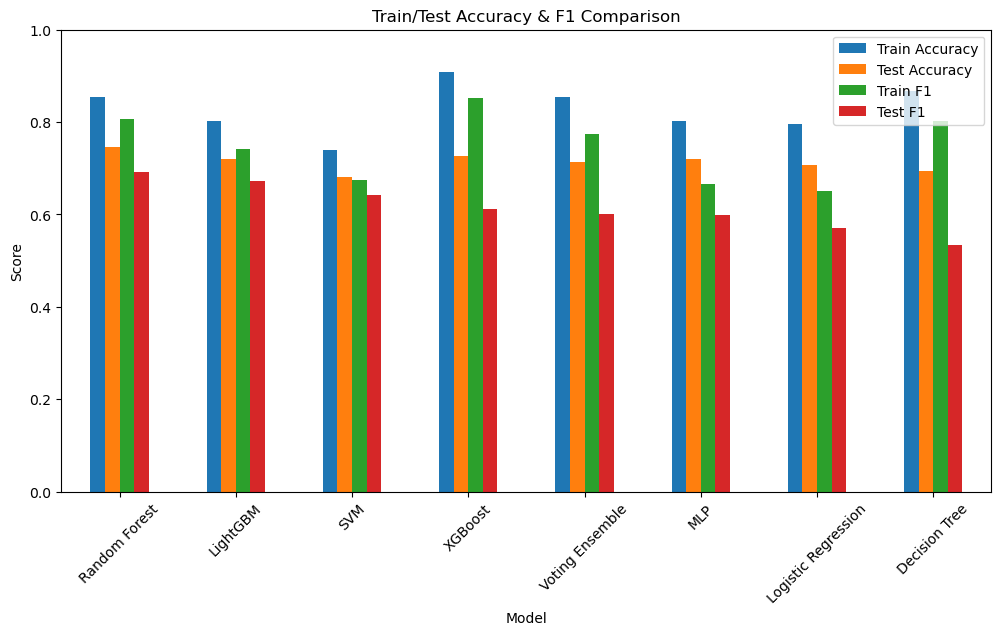

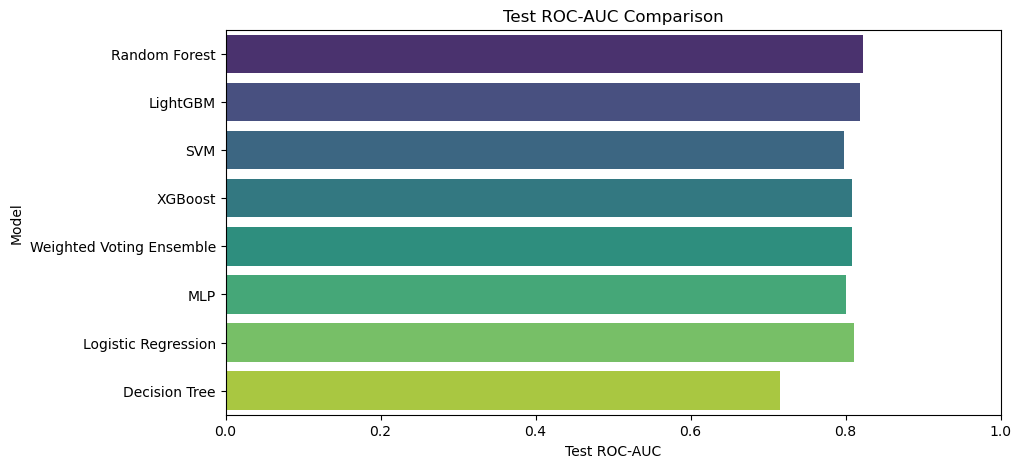

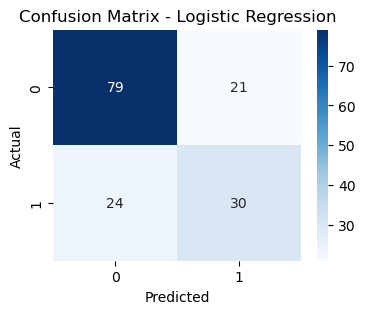

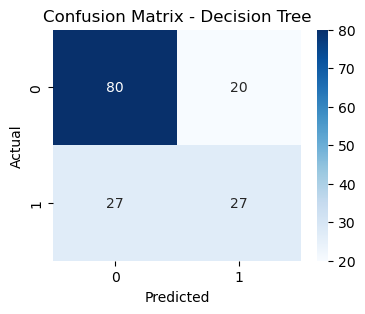

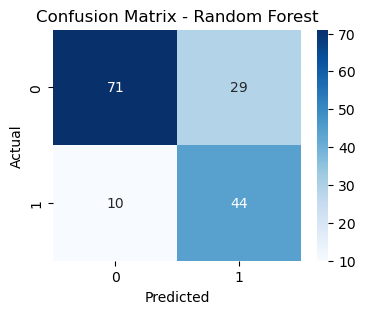

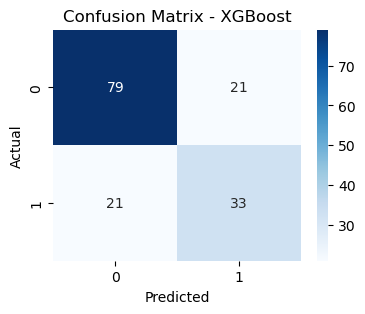

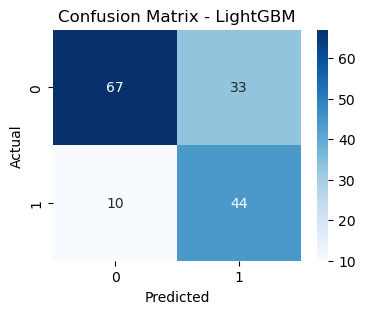

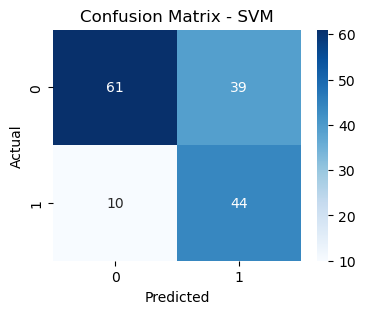

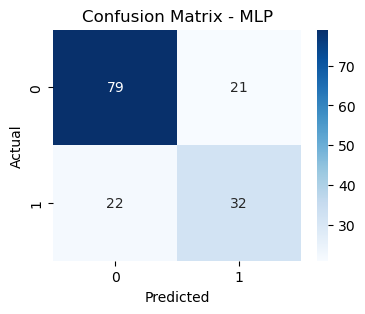

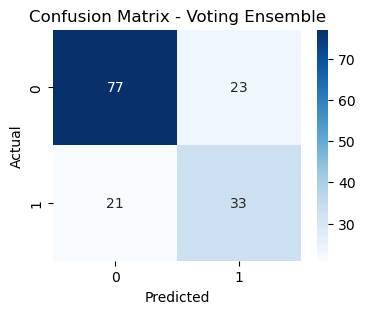

<Figure size 800x600 with 0 Axes>

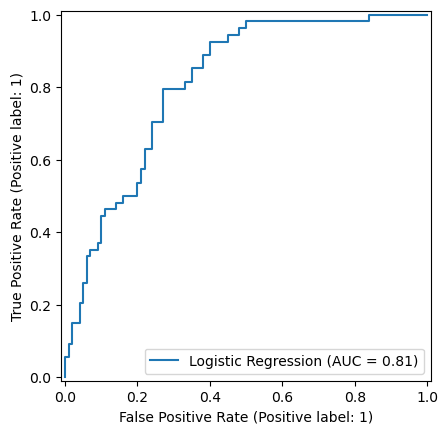

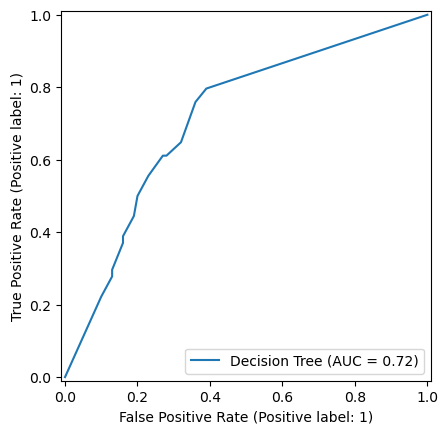

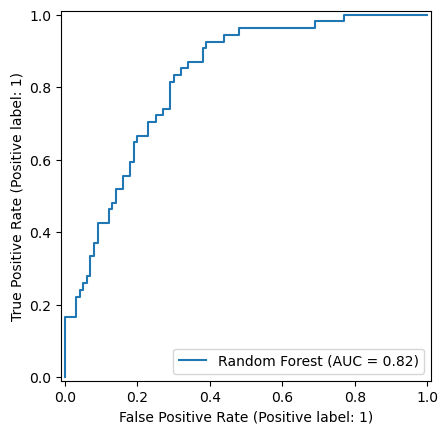

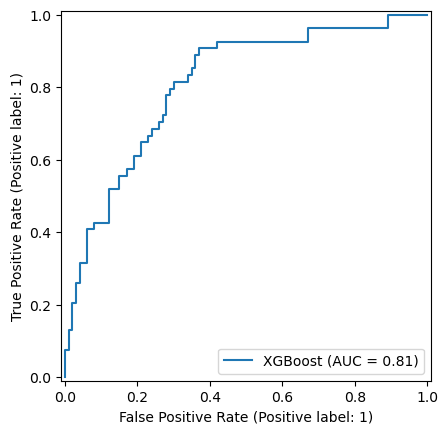

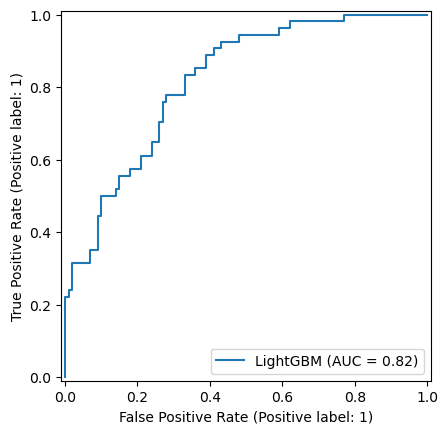

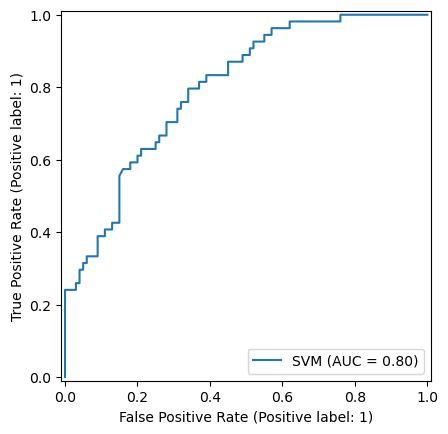

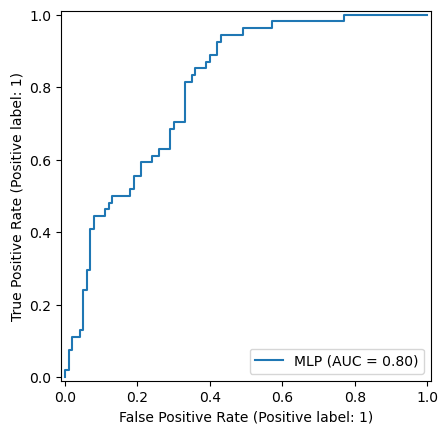

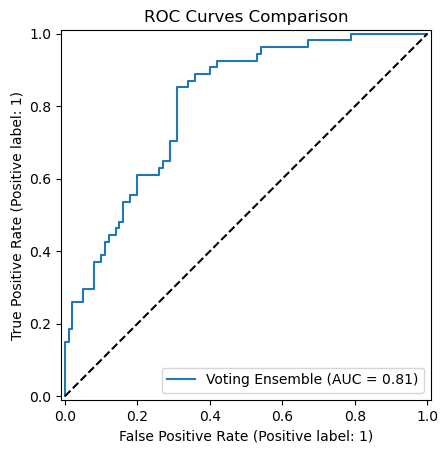

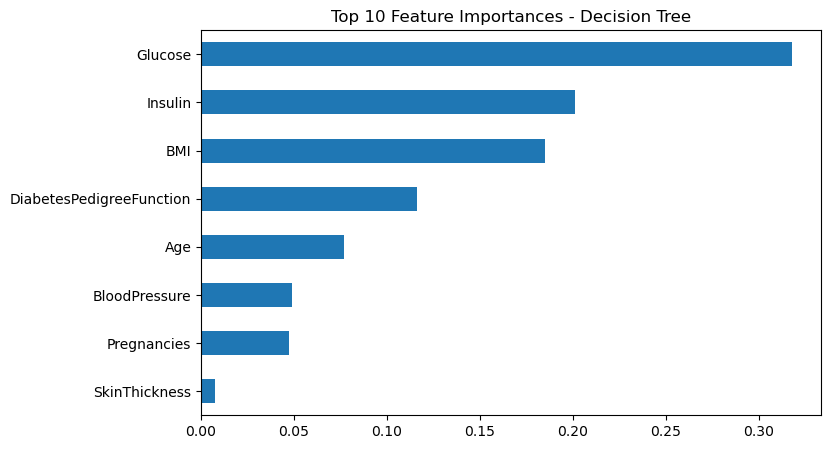

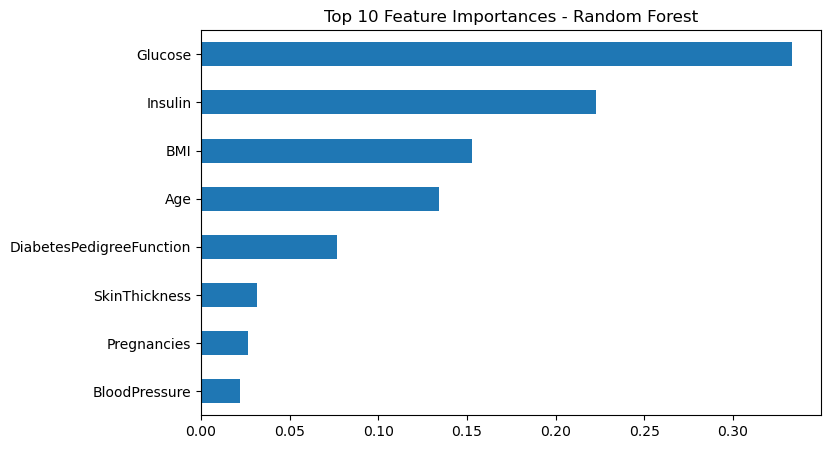

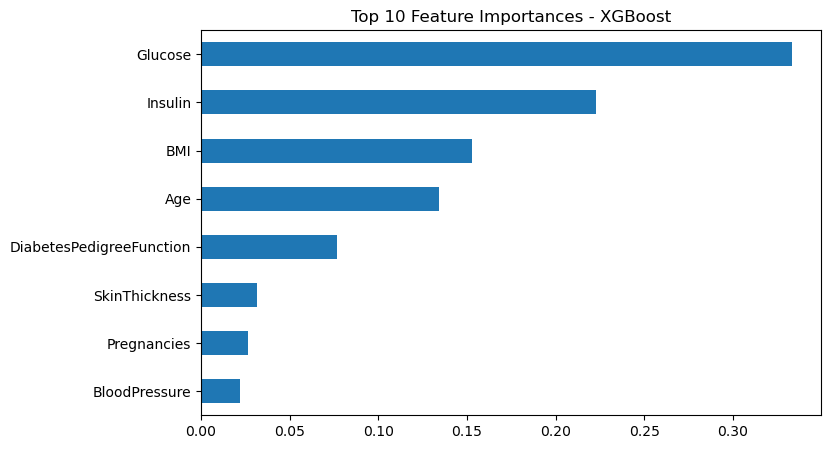

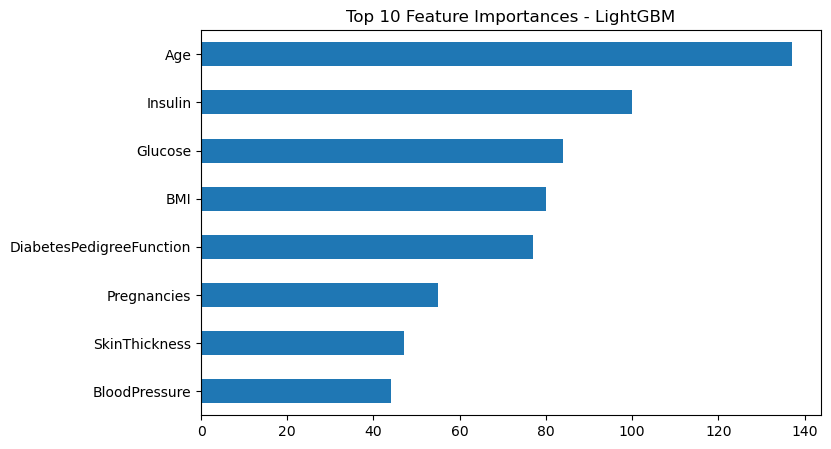

In [173]:
# --------------------------
# Complete Model Comparison Report
# --------------------------
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, RocCurveDisplay, confusion_matrix
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

# --------------------------
# 1) Load best models
# --------------------------
best_log = joblib.load("logreg_best.pkl")
best_dt  = joblib.load("dt_best.pkl")
best_rf  = joblib.load("rf_best_randomized.pkl")
best_xgb = joblib.load("xgb_best_randomized.pkl")
best_lgb = joblib.load("lgb_best_randomized.pkl")
best_svc = joblib.load("svc_best.pkl")
best_mlp = joblib.load("mlp_best_randomized_v3.pkl")

# Voting Ensemble
voting_clf = VotingClassifier(
    estimators=[
        ('lr', best_log),
        ('dt', best_dt),
        ('rf', best_rf),
        ('xgb', best_xgb),
        ('lgbm', best_lgb),
        ('svc', best_svc),
        ('mlp', best_mlp)
    ],
    voting='soft',
    n_jobs=-1
)
voting_clf.fit(X_train_scaled, y_train_clean)

# --------------------------
# 2) Models list
# --------------------------
models = [
    ("Logistic Regression", best_log),
    ("Decision Tree", best_dt),
    ("Random Forest", best_rf),
    ("XGBoost", best_xgb),
    ("LightGBM", best_lgb),
    ("SVM", best_svc),
    ("MLP", best_mlp),
    ("Voting Ensemble", voting_clf)
]

# --------------------------
# 3) Evaluate all models
# --------------------------
results = []
roc_data = {}
cm_data = {}

for name, model in models:
    y_train_pred = model.predict(X_train_scaled)
    y_test_pred  = model.predict(X_test_scaled)

    train_acc = accuracy_score(y_train_clean, y_train_pred)
    test_acc  = accuracy_score(y_test_clean, y_test_pred)
    train_f1  = f1_score(y_train_clean, y_train_pred)
    test_f1   = f1_score(y_test_clean, y_test_pred)

    if hasattr(model, "predict_proba"):
        y_test_proba = model.predict_proba(X_test_scaled)[:, 1]
        test_roc_auc = roc_auc_score(y_test_clean, y_test_proba)
        roc_data[name] = (y_test_clean, y_test_proba)
    else:
        test_roc_auc = None

    cm_data[name] = confusion_matrix(y_test_clean, y_test_pred)

    results.append({
        "Model": name,
        "Train Accuracy": train_acc,
        "Test Accuracy": test_acc,
        "Train F1": train_f1,
        "Test F1": test_f1,
        "Test ROC-AUC": test_roc_auc
    })

# --------------------------
# 4) Summary DataFrame
# --------------------------
results_df = pd.DataFrame(results)
results_df = results_df[["Model","Train Accuracy","Test Accuracy","Train F1","Test F1","Test ROC-AUC"]]
results_df = results_df.sort_values(by="Test F1", ascending=False)
display(results_df)

# --------------------------
# 5) Accuracy & F1 Bar Plots
# --------------------------
metrics = ["Train Accuracy","Test Accuracy","Train F1","Test F1"]
results_df.plot(x="Model", y=metrics, kind="bar", figsize=(12,6))
plt.title("Train/Test Accuracy & F1 Comparison")
plt.xticks(rotation=45)
plt.ylabel("Score")
plt.ylim(0,1)
plt.show()

# --------------------------
# 6) ROC-AUC Bar Plot
# --------------------------
plt.figure(figsize=(10,5))
sns.barplot(
    x="Test ROC-AUC",
    y="Model",
    data=roc_auc_df,
    palette="viridis",
    hue="Model",     # Add hue
    dodge=False       # Avoid splitting bars
)
plt.legend([],[], frameon=False)  # Remove legend
plt.title("Test ROC-AUC Comparison")
plt.xlim(0,1)
plt.show()


# --------------------------
# 7) Confusion Matrices
# --------------------------
for name, cm in cm_data.items():
    plt.figure(figsize=(4,3))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.title(f"Confusion Matrix - {name}")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

# --------------------------
# 8) ROC Curves
# --------------------------
plt.figure(figsize=(8,6))
for name, (y_true, y_proba) in roc_data.items():
    RocCurveDisplay.from_predictions(y_true, y_proba, name=name)
plt.plot([0,1],[0,1],"k--")
plt.title("ROC Curves Comparison")
plt.show()

# --------------------------
# 9) Feature Importance (Tree Models)
# --------------------------
tree_models = {
    "Decision Tree": best_dt,
    "Random Forest": best_rf,
    "XGBoost": best_xgb,
    "LightGBM": best_lgb
}

for name, model in tree_models.items():
    if name in ["Decision Tree", "Random Forest"]:
        fi = pd.Series(model.feature_importances_, index=X_train_scaled.columns)
    elif name == "LightGBM":
        fi = pd.Series(model.feature_importances_, index=X_train_scaled.columns)

    fi = fi.sort_values(ascending=False)
    plt.figure(figsize=(8,5))
    fi.head(10).plot(kind="barh")
    plt.gca().invert_yaxis()
    plt.title(f"Top 10 Feature Importances - {name}")
    plt.show()


## Final Result

In [178]:

results_df = pd.DataFrame(results)
results_df = results_df[["Model","Train Accuracy","Test Accuracy","Train F1","Test F1","Test ROC-AUC"]]
results_df = results_df.sort_values(by="Test F1", ascending=False)
display(results_df)

,Model,Train Accuracy,Test Accuracy,Train F1,Test F1,Test ROC-AUC
2,Random Forest,0.853357,0.746753,0.805621,0.692913,0.822037
4,LightGBM,0.802120,0.720779,0.740741,0.671756,0.818519
5,SVM,0.740283,0.681818,0.674058,0.642336,0.798241
3,XGBoost,0.908127,0.727273,0.852273,0.611111,0.808889
7,Voting Ensemble,0.855124,0.714286,0.774725,0.600000,0.806667
6,MLP,0.802120,0.720779,0.666667,0.598131,0.800741
0,Logistic Regression,0.796820,0.707792,0.650456,0.571429,0.810926
1,Decision Tree,0.867491,0.694805,0.802111,0.534653,0.715648
